#Importing Necessary Libraries


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

**Load the text data files**

In [82]:
agency = pd.read_csv('/content/Dataset/agency.txt')
calendar = pd.read_csv('/content/Dataset/calendar.txt')
routes = pd.read_csv('/content/Dataset/routes.txt')
shapes = pd.read_csv('/content/Dataset/shapes.txt')
stop_times = pd.read_csv('/content/Dataset/stop_times.txt')
stops = pd.read_csv('/content/Dataset/stops.txt')
trips = pd.read_csv('/content/Dataset/trips.txt')

**Displaying First Few Rows and Structure of DataFrames**

In [83]:
data= {
    "agency": agency.head(),
    "calendar": calendar.head(),
    "routes": routes.head(),
    "shapes": shapes.head(),
    "stop_times": stop_times.head(),
    "stops": stops.head(),
    "trips": trips.head()
}

In [84]:
data

{'agency':   agency_id                   agency_name                      agency_url  \
 0      DMRC  Delhi Metro Rail Corporation  http://www.delhimetrorail.com/   
 
   agency_timezone  agency_lang  agency_phone  agency_fare_url  agency_email  
 0    Asia/Kolkata          NaN           NaN              NaN           NaN  ,
 'calendar':   service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
 0    weekday       1        1          1         1       1         0       0   
 1   saturday       0        0          0         0       0         1       0   
 2     sunday       0        0          0         0       0         0       1   
 
    start_date  end_date  
 0    20190101  20251231  
 1    20190101  20251231  
 2    20190101  20251231  ,
 'routes':    route_id  agency_id route_short_name  \
 0        33        NaN           R_SP_R   
 1        31        NaN           G_DD_R   
 2        29        NaN           P_MS_R   
 3        12        NaN             M_JB

**Plotting the Geographical routes on a map to visualize the network**

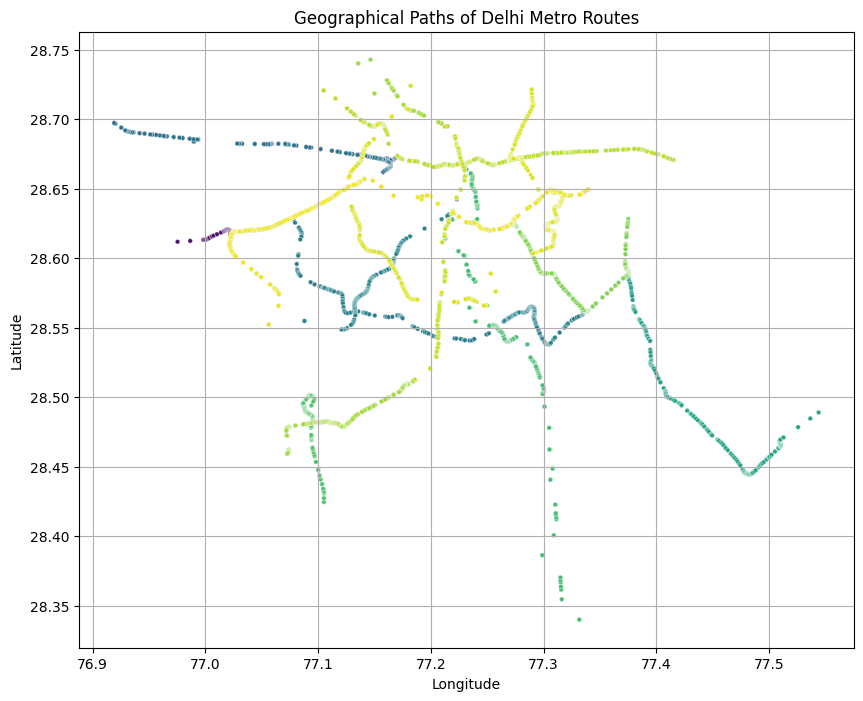

In [85]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='shape_pt_lon', y='shape_pt_lat', hue='shape_id', data=shapes, palette='viridis', s=10, legend=None)
plt.title('Geographical Paths of Delhi Metro Routes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

**Analyze the frequency and scheduling of trips across various days of the week by examining the calendar and trip data**

In [86]:
# Merge trips with calendar to include the day of operation information
trips_calendar = pd.merge(trips, calendar, on='service_id', how='left')

# Count the number of trips per day of the week
trip_counts = trips_calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum()

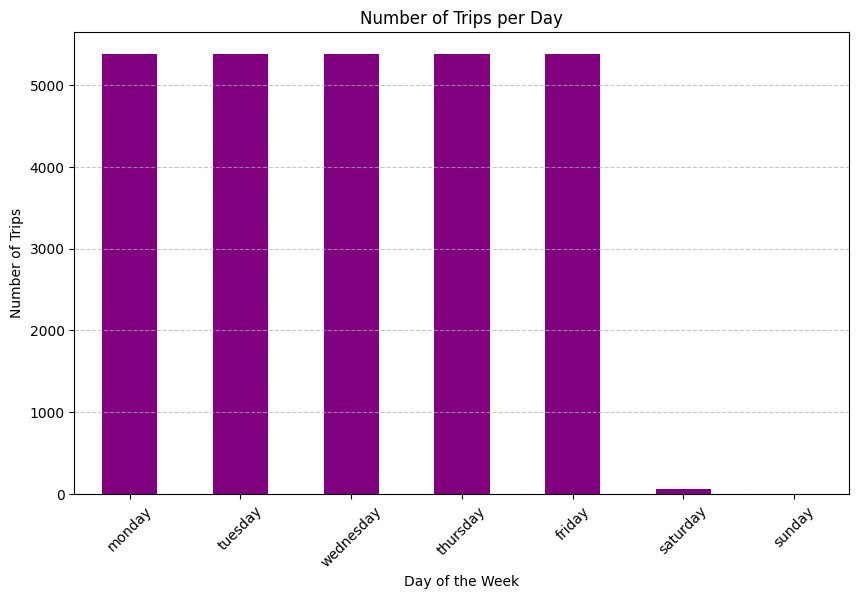

In [87]:
#Plotting
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color='purple')
plt.title('Number of Trips per Day')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**To delve deeper into analyzing the connectivity and effectiveness of the route strategy, I will examine the distribution and connectivity of stops**

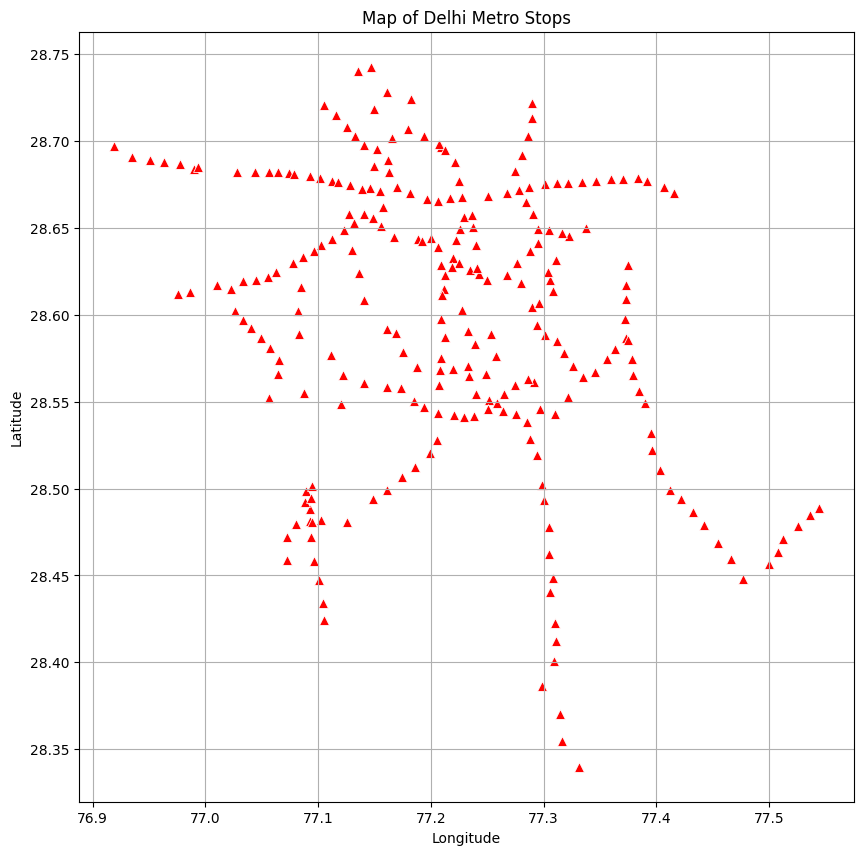

In [88]:
# Plotting the locations of the stops
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', data=stops, color='red', s=50, marker='^')
plt.title('Map of Delhi Metro Stops')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

**Analyzing the route complexity**

In [89]:
# Merge stops with stop_times to link each stop with trips, and then merge with trips to get route information
stops_with_routes = pd.merge(pd.merge(stop_times, trips, on='trip_id'), routes, on='route_id')

# Count how many unique routes pass through each stop
stop_route_counts = stops_with_routes.groupby('stop_id')['route_id'].nunique().reset_index()
stop_route_counts = stop_route_counts.rename(columns={'route_id': 'number_of_routes'})

# Merge this with stops to get the names and location for plotting
stop_route_counts = pd.merge(stop_route_counts, stops, on='stop_id')

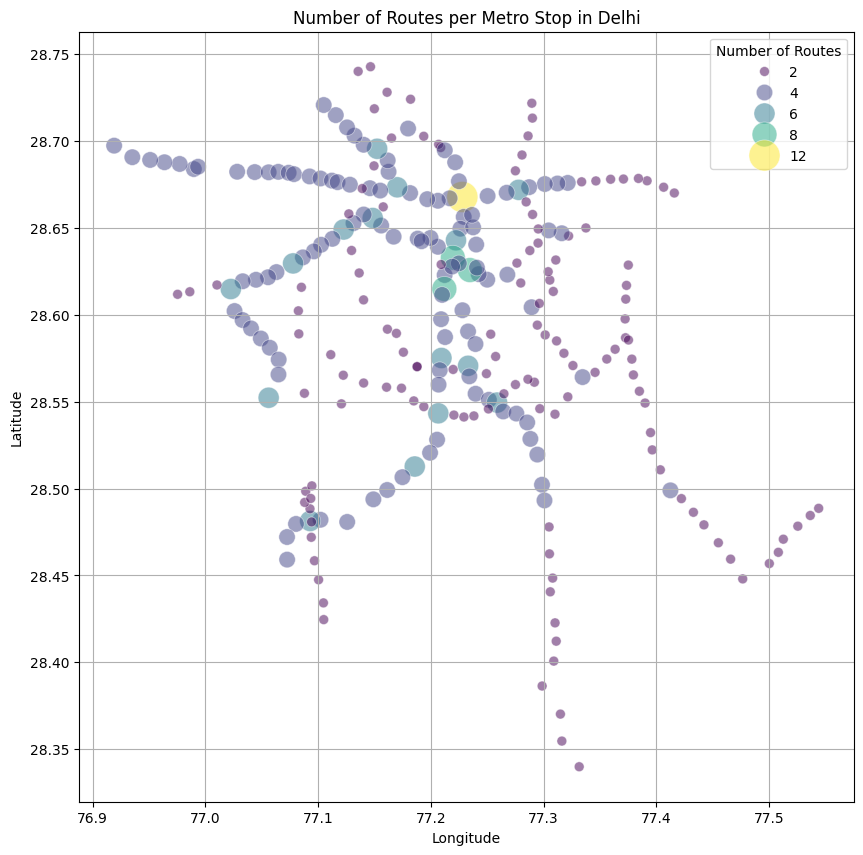

In [90]:
# Plot the number of routes per stop
plt.figure(figsize=(10, 10))
sns.scatterplot(x='stop_lon', y='stop_lat', size='number_of_routes', hue='number_of_routes',
                sizes=(50, 500), alpha=0.5, palette='viridis', data=stop_route_counts)
plt.title('Number of Routes per Metro Stop in Delhi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Number of Routes')
plt.grid(True)
plt.show()

**Analyzing trip frequency by examining timing intervals throughout the day to optimize commuter flow management strategies**

In [91]:
# Function to convert time string to datetime.time
def convert_to_time(time_str):
    try:
        return dt.datetime.strptime(time_str, '%H:%M:%S').time()
    except ValueError:
        # Handle cases where the hour might be greater than 23 (e.g., 24:00:00 or 25:00:00)
        hour, minute, second = map(int, time_str.split(':'))
        return dt.time(hour % 24, minute, second)

stop_times['arrival_time_dt'] = stop_times['arrival_time'].apply(convert_to_time)

# Calculate the difference in arrival times for subsequent trips at each stop
stop_times_sorted = stop_times.sort_values(by=['stop_id', 'arrival_time_dt'])
stop_times_sorted['next_arrival_time'] = stop_times_sorted.groupby('stop_id')['arrival_time_dt'].shift(-1)

# Function to calculate the difference in minutes between two times
def time_difference(time1, time2):
    if pd.isna(time1) or pd.isna(time2):
        return None
    full_date_time1 = dt.datetime.combine(dt.date.today(), time1)
    full_date_time2 = dt.datetime.combine(dt.date.today(), time2)
    return (full_date_time2 - full_date_time1).seconds / 60

stop_times_sorted['interval_minutes'] = stop_times_sorted.apply(lambda row: time_difference(row['arrival_time_dt'], row['next_arrival_time']), axis=1)

# drop NaN values from intervals (last trip of the day)
stop_times_intervals = stop_times_sorted.dropna(subset=['interval_minutes'])

# average intervals by time of day (morning, afternoon, evening)
def part_of_day(time):
    if time < dt.time(12, 0):
        return 'Morning'
    elif time < dt.time(17, 0):
        return 'Afternoon'
    else:
        return 'Evening'
stop_times_intervals = stop_times_intervals.copy()
stop_times_intervals.loc[:, 'part_of_day'] = stop_times_intervals['arrival_time_dt'].apply(part_of_day)
average_intervals = stop_times_intervals.groupby('part_of_day')['interval_minutes'].mean().reset_index()

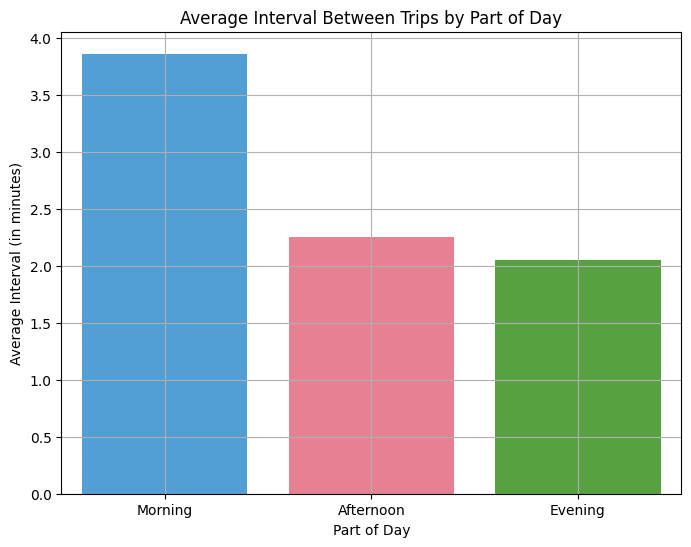

In [92]:
#Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='part_of_day', y='interval_minutes', data=average_intervals, order=['Morning', 'Afternoon', 'Evening'], palette='husl', hue='part_of_day', legend=False)
plt.title('Average Interval Between Trips by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Average Interval (in minutes)')
plt.grid(True)
plt.show()


**Calculate the number of trips and available capacity per time interval to understand how service levels vary throughout the day**

In [93]:
# Define time intervals for classification
def classify_time_interval(time):
    if time < dt.time(6, 0):
        return 'Early Morning'
    elif time < dt.time(10, 0):
        return 'Morning Peak'
    elif time < dt.time(16, 0):
        return 'Midday'
    elif time < dt.time(20, 0):
        return 'Evening Peak'
    else:
        return 'Late Evening'

# apply time interval classification
stop_times['time_interval'] = stop_times['arrival_time_dt'].apply(classify_time_interval)

# count the number of trips per time interval
trips_per_interval = stop_times.groupby('time_interval')['trip_id'].nunique().reset_index()
trips_per_interval = trips_per_interval.rename(columns={'trip_id': 'number_of_trips'})

# sorting the dataframe
ordered_intervals = ['Early Morning', 'Morning Peak', 'Midday', 'Evening Peak', 'Late Evening']
trips_per_interval['time_interval'] = pd.Categorical(trips_per_interval['time_interval'], categories=ordered_intervals, ordered=True)
trips_per_interval = trips_per_interval.sort_values('time_interval')

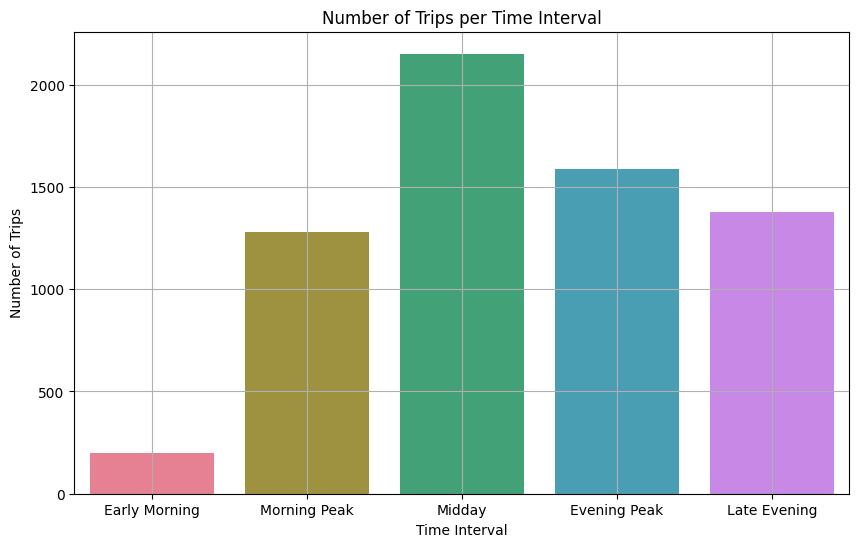

In [94]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='time_interval', y='number_of_trips', data=trips_per_interval, palette='husl', hue='time_interval', legend=False)
plt.title('Number of Trips per Time Interval')
plt.xlabel('Time Interval')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

**Refining the frequencies of trains during peak and off-peak hours based on the trip frequency analysis performed earlier**

In [95]:
# Adjusting frequencies based on hypothetical scenario
adjusted_trips_per_interval = trips_per_interval.copy()
adjustment_factors = {'Morning Peak': 1.20, 'Evening Peak': 1.20, 'Midday': 0.90, 'Early Morning': 1.0, 'Late Evening': 0.90}

# Apply the adjustments
adjusted_trips_per_interval['adjusted_number_of_trips'] = adjusted_trips_per_interval.apply(
    lambda row: int(row['number_of_trips'] * adjustment_factors[row['time_interval']]), axis=1)

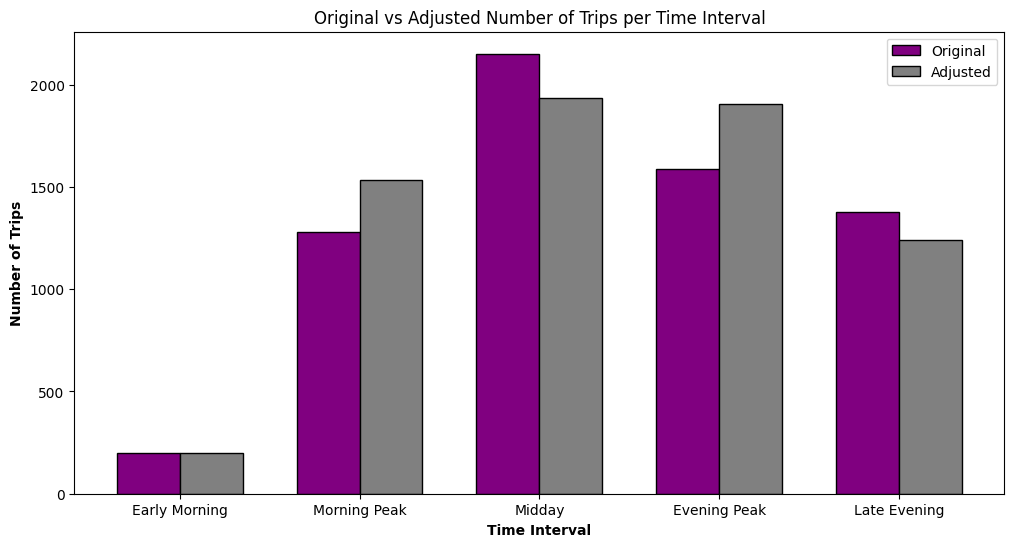

In [96]:
# Plotting
plt.figure(figsize=(12, 6))
bar_width = 0.35
r1 = range(len(adjusted_trips_per_interval))
r2 = [x + bar_width for x in r1]

plt.bar(r1, adjusted_trips_per_interval['number_of_trips'], color='purple', width=bar_width, edgecolor='black', label='Original')
plt.bar(r2, adjusted_trips_per_interval['adjusted_number_of_trips'], color='grey', width=bar_width, edgecolor='black', label='Adjusted')

plt.xlabel('Time Interval', fontweight='bold')
plt.ylabel('Number of Trips', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(adjusted_trips_per_interval))], adjusted_trips_per_interval['time_interval'])
plt.title('Original vs Adjusted Number of Trips per Time Interval')
plt.legend()
plt.show()